In [1]:
# IMPORT LIBRARIES - VIZENV ENVIRONMENT
import pandas as pd
from pathlib import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import hvplot.pandas
import warnings
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
# bring in data
data_location = Path("../Histories/joined_forexdata.csv")
df = pd.read_csv(data_location)
df.head()

,DateTime,Open,High,Low,Close,Volume
0,2020-02-02 17:00,1.10939,1.10939,1.10939,1.10939,0.0
1,2020-02-02 17:01,1.10934,1.10934,1.10921,1.10921,0.0
2,2020-02-02 17:02,1.10922,1.10922,1.10922,1.10922,0.0
3,2020-02-02 17:03,1.10923,1.10923,1.10918,1.10918,0.0
4,2020-02-02 17:04,1.10921,1.10921,1.10921,1.10921,0.0


In [3]:
# REASIGN INDEX TO DATE-TIME AND DROP EXTRA COLUMN
df.set_index(df["DateTime"], inplace = True)
df = df.drop(columns = "DateTime")
df.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2020-02-02 17:00,1.10939,1.10939,1.10939,1.10939,0.0
2020-02-02 17:01,1.10934,1.10934,1.10921,1.10921,0.0
2020-02-02 17:02,1.10922,1.10922,1.10922,1.10922,0.0
2020-02-02 17:03,1.10923,1.10923,1.10918,1.10918,0.0
2020-02-02 17:04,1.10921,1.10921,1.10921,1.10921,0.0


In [4]:
# df.index
#DROP NAs and calculate returns minute over minute
df['return'] = df['Close'].dropna().pct_change()
df.head()

,Open,High,Low,Close,Volume,return
DateTime,,,,,,
2020-02-02 17:00,1.10939,1.10939,1.10939,1.10939,0.0,NaN
2020-02-02 17:01,1.10934,1.10934,1.10921,1.10921,0.0,-0.000162
2020-02-02 17:02,1.10922,1.10922,1.10922,1.10922,0.0,0.000009
2020-02-02 17:03,1.10923,1.10923,1.10918,1.10918,0.0,-0.000036
2020-02-02 17:04,1.10921,1.10921,1.10921,1.10921,0.0,0.000027


In [5]:
# convert index to date_time
df.index = pd.to_datetime(df.index)

In [6]:
# Set short and long windows
short_window = 60
long_window = 240

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_close'] = df['Close'].ewm(halflife=short_window).mean()
df['slow_close'] = df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df['crossover_long'] = np.where(df['fast_close'] > df['slow_close'], 1.0, 0.0)
df['crossover_short'] = np.where(df['fast_close'] < df['slow_close'], -1.0, 0.0)
df['crossover_signal'] = df['crossover_long'] + df['crossover_short']

# df.head()

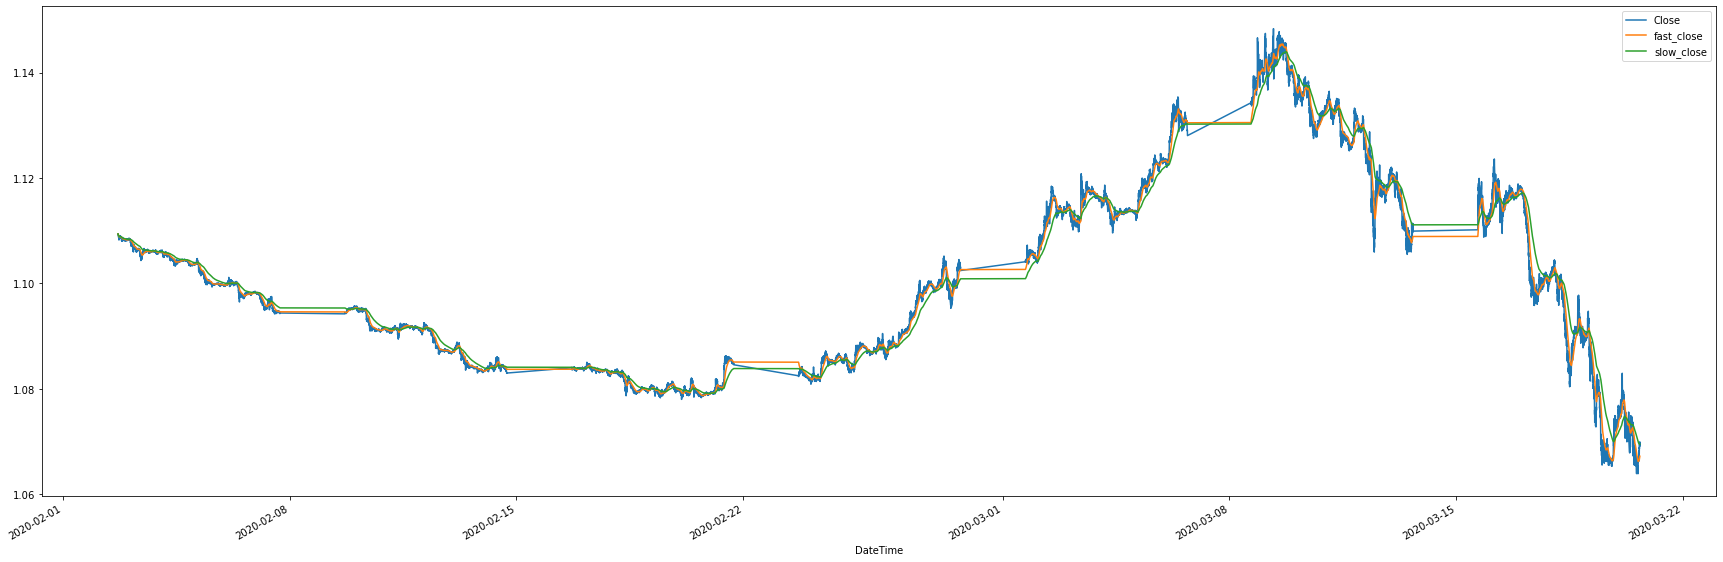

In [7]:
# Plot the EMA of EURUSD closing prices
df[['Close', 'fast_close', 'slow_close']].plot(figsize=(30,10))

In [8]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
# had to use rolling window of 30 in order to get predictions, may need to investigate further
df['bollinger_mid_band'] = df['Close'].rolling(window=bollinger_window).mean()
df['bollinger_std'] = df['Close'].rolling(window=30).std()

# Calculate upper and lowers bands of bollinger band using std for bands
df['bollinger_upper_band']  = df['bollinger_mid_band'] + (df['bollinger_std'] * 1)
df['bollinger_lower_band']  = df['bollinger_mid_band'] - (df['bollinger_std'] * 1)
# df['bollinger_lower_band']  = df['bollinger_mid_band']

# Calculate bollinger band trading signal
df['bollinger_long'] = np.where(df['Close'] < df['bollinger_lower_band'], 1.0, 0.0)
df['bollinger_short'] = np.where(df['Close'] > df['bollinger_upper_band'], -1.0, 0.0)
df['bollinger_signal'] = df['bollinger_long'] + df['bollinger_short']

df

,Open,High,Low,Close,Volume,return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
DateTime,,,,,,,,,,,,,,,,,,
2020-02-02 17:00:00,1.10939,1.10939,1.10939,1.10939,0.0,NaN,1.109390,1.109390,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-02-02 17:01:00,1.10934,1.10934,1.10921,1.10921,0.0,-0.000162,1.109299,1.109300,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-02-02 17:02:00,1.10922,1.10922,1.10922,1.10922,0.0,0.000009,1.109273,1.109273,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-02-02 17:03:00,1.10923,1.10923,1.10918,1.10918,0.0,-0.000036,1.109249,1.109250,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-02-02 17:04:00,1.10921,1.10921,1.10921,1.10921,0.0,0.000027,1.109241,1.109242,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20 15:54:00,1.06985,1.06993,1.06936,1.06937,0.0,-0.000449,1.067085,1.069481,0.0,-1.0,-1.0,1.069219,0.001190,1.070409,1.068029,0.0,0.0,0.0
2020-03-20 15:55:00,1.06936,1.07002,1.06936,1.06976,0.0,0.000365,1.067116,1.069482,0.0,-1.0,-1.0,1.069273,0.001138,1.070412,1.068135,0.0,0.0,0.0
2020-03-20 15:56:00,1.06968,1.06997,1.06968,1.06978,0.0,0.000019,1.067147,1.069482,0.0,-1.0,-1.0,1.069318,0.001083,1.070402,1.068235,0.0,0.0,0.0


In [9]:
# drop NAs and review df
df = df.dropna()
df

,Open,High,Low,Close,Volume,return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
DateTime,,,,,,,,,,,,,,,,,,
2020-02-02 17:29:00,1.10904,1.10907,1.10903,1.10903,0.0,0.000000,1.109082,1.109092,0.0,-1.0,-1.0,1.109034,0.000155,1.109189,1.108879,0.0,0.0,0.0
2020-02-02 17:30:00,1.10903,1.10906,1.10872,1.10872,0.0,-0.000280,1.109068,1.109079,0.0,-1.0,-1.0,1.109011,0.000160,1.109170,1.108851,1.0,0.0,1.0
2020-02-02 17:31:00,1.10871,1.10884,1.10869,1.10875,0.0,0.000027,1.109057,1.109069,0.0,-1.0,-1.0,1.108989,0.000168,1.109157,1.108821,1.0,0.0,1.0
2020-02-02 17:32:00,1.10874,1.10876,1.10866,1.10876,0.0,0.000009,1.109046,1.109059,0.0,-1.0,-1.0,1.108968,0.000173,1.109141,1.108794,1.0,0.0,1.0
2020-02-02 17:33:00,1.10874,1.10878,1.10859,1.10866,0.0,-0.000090,1.109032,1.109046,0.0,-1.0,-1.0,1.108942,0.000185,1.109126,1.108757,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20 15:54:00,1.06985,1.06993,1.06936,1.06937,0.0,-0.000449,1.067085,1.069481,0.0,-1.0,-1.0,1.069219,0.001190,1.070409,1.068029,0.0,0.0,0.0
2020-03-20 15:55:00,1.06936,1.07002,1.06936,1.06976,0.0,0.000365,1.067116,1.069482,0.0,-1.0,-1.0,1.069273,0.001138,1.070412,1.068135,0.0,0.0,0.0
2020-03-20 15:56:00,1.06968,1.06997,1.06968,1.06978,0.0,0.000019,1.067147,1.069482,0.0,-1.0,-1.0,1.069318,0.001083,1.070402,1.068235,0.0,0.0,0.0


In [10]:
import matplotlib.pyplot as plt

In [11]:
# verify index is datetime
df.index

DatetimeIndex(['2020-02-02 17:29:00', '2020-02-02 17:30:00',
               '2020-02-02 17:31:00', '2020-02-02 17:32:00',
               '2020-02-02 17:33:00', '2020-02-02 17:34:00',
               '2020-02-02 17:35:00', '2020-02-02 17:36:00',
               '2020-02-02 17:37:00', '2020-02-02 17:38:00',
               ...
               '2020-03-20 15:49:00', '2020-03-20 15:50:00',
               '2020-03-20 15:51:00', '2020-03-20 15:52:00',
               '2020-03-20 15:53:00', '2020-03-20 15:54:00',
               '2020-03-20 15:55:00', '2020-03-20 15:56:00',
               '2020-03-20 15:57:00', '2020-03-20 15:58:00'],
              dtype='datetime64[ns]', name='DateTime', length=50262, freq=None)

In [12]:
# review of bollinger band for a set day
df2 = df.loc[: ,]['2020-03-20']

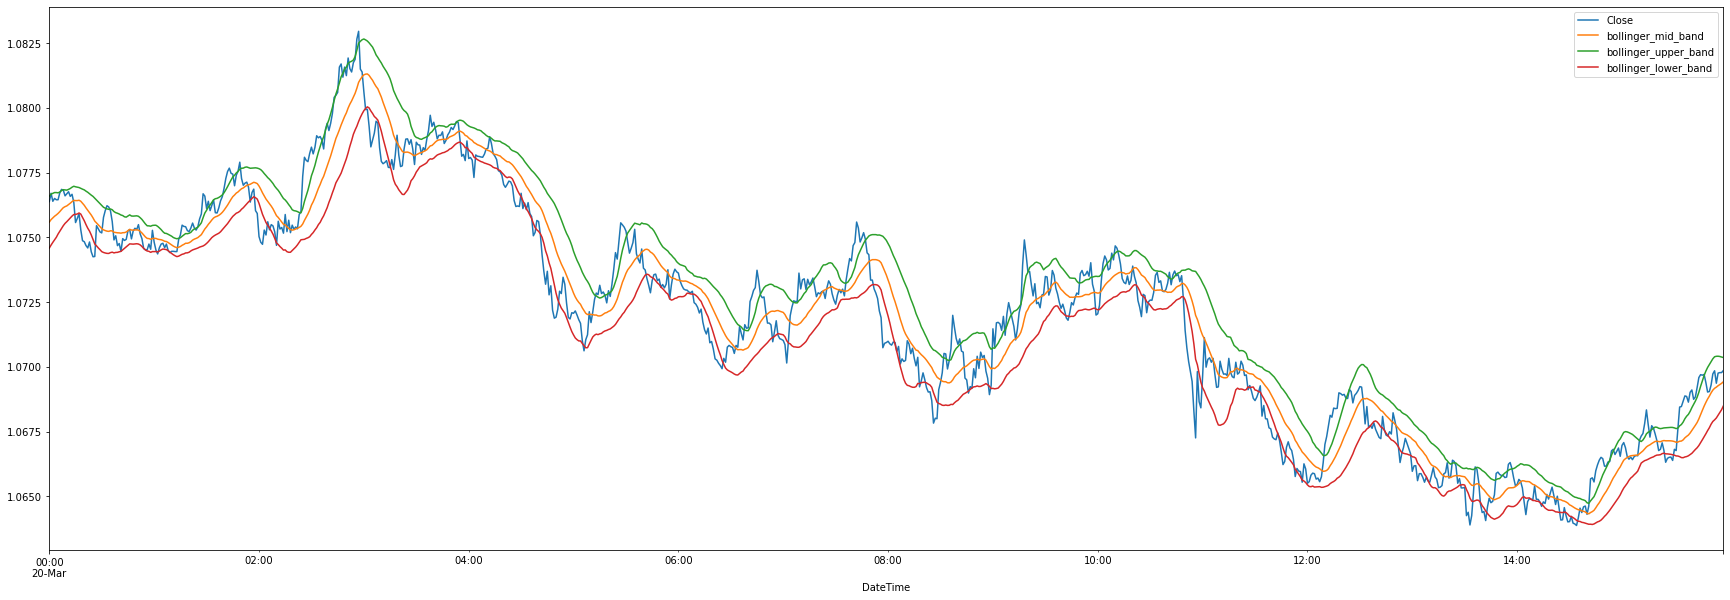

In [13]:
# df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))
df2[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(30,10))

In [14]:
df.head()

,Open,High,Low,Close,Volume,return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
DateTime,,,,,,,,,,,,,,,,,,
2020-02-02 17:29:00,1.10904,1.10907,1.10903,1.10903,0.0,0.000000,1.109082,1.109092,0.0,-1.0,-1.0,1.109034,0.000155,1.109189,1.108879,0.0,0.0,0.0
2020-02-02 17:30:00,1.10903,1.10906,1.10872,1.10872,0.0,-0.000280,1.109068,1.109079,0.0,-1.0,-1.0,1.109011,0.000160,1.109170,1.108851,1.0,0.0,1.0
2020-02-02 17:31:00,1.10871,1.10884,1.10869,1.10875,0.0,0.000027,1.109057,1.109069,0.0,-1.0,-1.0,1.108989,0.000168,1.109157,1.108821,1.0,0.0,1.0
2020-02-02 17:32:00,1.10874,1.10876,1.10866,1.10876,0.0,0.000009,1.109046,1.109059,0.0,-1.0,-1.0,1.108968,0.000173,1.109141,1.108794,1.0,0.0,1.0
2020-02-02 17:33:00,1.10874,1.10878,1.10859,1.10866,0.0,-0.000090,1.109032,1.109046,0.0,-1.0,-1.0,1.108942,0.000185,1.109126,1.108757,1.0,0.0,1.0


In [15]:
# features for testing
var_list = ['crossover_signal','bollinger_signal']
# var_list = ['bollinger_signal']
df[var_list].head(5)

,crossover_signal,bollinger_signal
DateTime,,
2020-02-02 17:29:00,-1.0,0.0
2020-02-02 17:30:00,-1.0,1.0
2020-02-02 17:31:00,-1.0,1.0
2020-02-02 17:32:00,-1.0,1.0
2020-02-02 17:33:00,-1.0,1.0


In [16]:
# Shift data DataFrame values for predictive model
df[var_list] = df[var_list].shift(1)
df[var_list].head(5)

,crossover_signal,bollinger_signal
DateTime,,
2020-02-02 17:29:00,NaN,NaN
2020-02-02 17:30:00,-1.0,0.0
2020-02-02 17:31:00,-1.0,1.0
2020-02-02 17:32:00,-1.0,1.0
2020-02-02 17:33:00,-1.0,1.0


In [17]:
df.head()

,Open,High,Low,Close,Volume,return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
DateTime,,,,,,,,,,,,,,,,,,
2020-02-02 17:29:00,1.10904,1.10907,1.10903,1.10903,0.0,0.000000,1.109082,1.109092,0.0,-1.0,NaN,1.109034,0.000155,1.109189,1.108879,0.0,0.0,NaN
2020-02-02 17:30:00,1.10903,1.10906,1.10872,1.10872,0.0,-0.000280,1.109068,1.109079,0.0,-1.0,-1.0,1.109011,0.000160,1.109170,1.108851,1.0,0.0,0.0
2020-02-02 17:31:00,1.10871,1.10884,1.10869,1.10875,0.0,0.000027,1.109057,1.109069,0.0,-1.0,-1.0,1.108989,0.000168,1.109157,1.108821,1.0,0.0,1.0
2020-02-02 17:32:00,1.10874,1.10876,1.10866,1.10876,0.0,0.000009,1.109046,1.109059,0.0,-1.0,-1.0,1.108968,0.000173,1.109141,1.108794,1.0,0.0,1.0
2020-02-02 17:33:00,1.10874,1.10878,1.10859,1.10866,0.0,-0.000090,1.109032,1.109046,0.0,-1.0,-1.0,1.108942,0.000185,1.109126,1.108757,1.0,0.0,1.0


In [18]:
# Drop NAs , get rid of infinities
df.dropna(subset=var_list, inplace=True)
df.dropna(subset=['return'], inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df.head()

,Open,High,Low,Close,Volume,return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
DateTime,,,,,,,,,,,,,,,,,,
2020-02-02 17:30:00,1.10903,1.10906,1.10872,1.10872,0.0,-0.000280,1.109068,1.109079,0.0,-1.0,-1.0,1.109011,0.000160,1.109170,1.108851,1.0,0.0,0.0
2020-02-02 17:31:00,1.10871,1.10884,1.10869,1.10875,0.0,0.000027,1.109057,1.109069,0.0,-1.0,-1.0,1.108989,0.000168,1.109157,1.108821,1.0,0.0,1.0
2020-02-02 17:32:00,1.10874,1.10876,1.10866,1.10876,0.0,0.000009,1.109046,1.109059,0.0,-1.0,-1.0,1.108968,0.000173,1.109141,1.108794,1.0,0.0,1.0
2020-02-02 17:33:00,1.10874,1.10878,1.10859,1.10866,0.0,-0.000090,1.109032,1.109046,0.0,-1.0,-1.0,1.108942,0.000185,1.109126,1.108757,1.0,0.0,1.0
2020-02-02 17:34:00,1.10864,1.10867,1.10858,1.10859,0.0,-0.000063,1.109017,1.109033,0.0,-1.0,-1.0,1.108913,0.000198,1.109111,1.108715,1.0,0.0,1.0


In [19]:
# training model on positive returns only
# at later date, should test on negative returns to see how it influences the model
df['Positive Return'] = np.where(df['return'] > 0, 1.0, 0.0)
df.head()

,Open,High,Low,Close,Volume,return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
DateTime,,,,,,,,,,,,,,,,,,,
2020-02-02 17:30:00,1.10903,1.10906,1.10872,1.10872,0.0,-0.000280,1.109068,1.109079,0.0,-1.0,-1.0,1.109011,0.000160,1.109170,1.108851,1.0,0.0,0.0,0.0
2020-02-02 17:31:00,1.10871,1.10884,1.10869,1.10875,0.0,0.000027,1.109057,1.109069,0.0,-1.0,-1.0,1.108989,0.000168,1.109157,1.108821,1.0,0.0,1.0,1.0
2020-02-02 17:32:00,1.10874,1.10876,1.10866,1.10876,0.0,0.000009,1.109046,1.109059,0.0,-1.0,-1.0,1.108968,0.000173,1.109141,1.108794,1.0,0.0,1.0,1.0
2020-02-02 17:33:00,1.10874,1.10878,1.10859,1.10866,0.0,-0.000090,1.109032,1.109046,0.0,-1.0,-1.0,1.108942,0.000185,1.109126,1.108757,1.0,0.0,1.0,0.0
2020-02-02 17:34:00,1.10864,1.10867,1.10858,1.10859,0.0,-0.000063,1.109017,1.109033,0.0,-1.0,-1.0,1.108913,0.000198,1.109111,1.108715,1.0,0.0,1.0,0.0


In [20]:
# Construct training start and end dates
# training_start = df.index.min().strftime(format= '%Y-%m-%d')
training_start = '2020-03-10'
training_end = '2020-03-16'

# Construct testing start and end dates
# too large a window leads to model never predicting 1
testing_start =  '2020-03-16'
testing_end = '2020-03-17'
# testing_end = df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2020-03-10
Training End: 2020-03-16
Testing Start: 2020-03-16
Testing End: 2020-03-17


In [21]:

x_train = df[var_list][training_start:training_end]
y_train = df['Positive Return'][training_start:training_end]

# x_train.tail()

In [22]:
# Construct the x test and y test datasets
x_test = df[var_list][testing_start:testing_end]
y_test = df['Positive Return'][testing_start:testing_end]

x_test.tail()

,crossover_signal,bollinger_signal
DateTime,,
2020-03-17 23:55:00,1.0,0.0
2020-03-17 23:56:00,1.0,0.0
2020-03-17 23:57:00,1.0,0.0
2020-03-17 23:58:00,1.0,0.0
2020-03-17 23:59:00,1.0,0.0


In [23]:
x_test.head()

,crossover_signal,bollinger_signal
DateTime,,
2020-03-16 00:00:00,-1.0,-1.0
2020-03-16 00:01:00,-1.0,-1.0
2020-03-16 00:02:00,-1.0,-1.0
2020-03-16 00:03:00,-1.0,0.0
2020-03-16 00:04:00,-1.0,0.0


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [25]:
# Fit model using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=15, max_depth=100, random_state=42)
# model = RandomForestClassifier(n_estimators=15, max_depth=5, random_state=42)
# model = RandomForestClassifier()
model.fit(x_train, y_train)

# Make a predictions
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
DateTime,,
2020-03-16 00:00:00,0.0,0.0
2020-03-16 00:01:00,0.0,0.0
2020-03-16 00:02:00,0.0,0.0
2020-03-16 00:03:00,0.0,0.0
2020-03-16 00:04:00,0.0,0.0
...,...,...
2020-03-17 23:55:00,0.0,0.0
2020-03-17 23:56:00,1.0,0.0
2020-03-17 23:57:00,1.0,0.0


In [26]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [27]:
Results.head()

,Positive Return,Predicted Value
DateTime,,
2020-03-16 00:00:00,0.0,0.0
2020-03-16 00:01:00,0.0,0.0
2020-03-16 00:02:00,0.0,0.0
2020-03-16 00:03:00,0.0,0.0
2020-03-16 00:04:00,0.0,0.0


In [28]:
# y_test.head()
from collections import Counter
Counter(y_test)

Counter({0.0: 1458, 1.0: 1422})

In [29]:
# ! pip install collections

In [30]:
# run model on x_test 
model = load('random_forest_model.joblib')
predictions = model.predict(x_test)
print(predictions)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [31]:
# Add predicted results to DataFrame
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
DateTime,,
2020-03-16 00:00:00,0.0,0.0
2020-03-16 00:01:00,0.0,0.0
2020-03-16 00:02:00,0.0,0.0
2020-03-16 00:03:00,0.0,0.0
2020-03-16 00:04:00,0.0,0.0
...,...,...
2020-03-17 23:55:00,0.0,0.0
2020-03-17 23:56:00,1.0,0.0
2020-03-17 23:57:00,1.0,0.0


In [32]:
# print classification report to review model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.51      0.90      0.65      1458
         1.0       0.50      0.10      0.17      1422

    accuracy                           0.51      2880
   macro avg       0.50      0.50      0.41      2880
weighted avg       0.50      0.51      0.41      2880



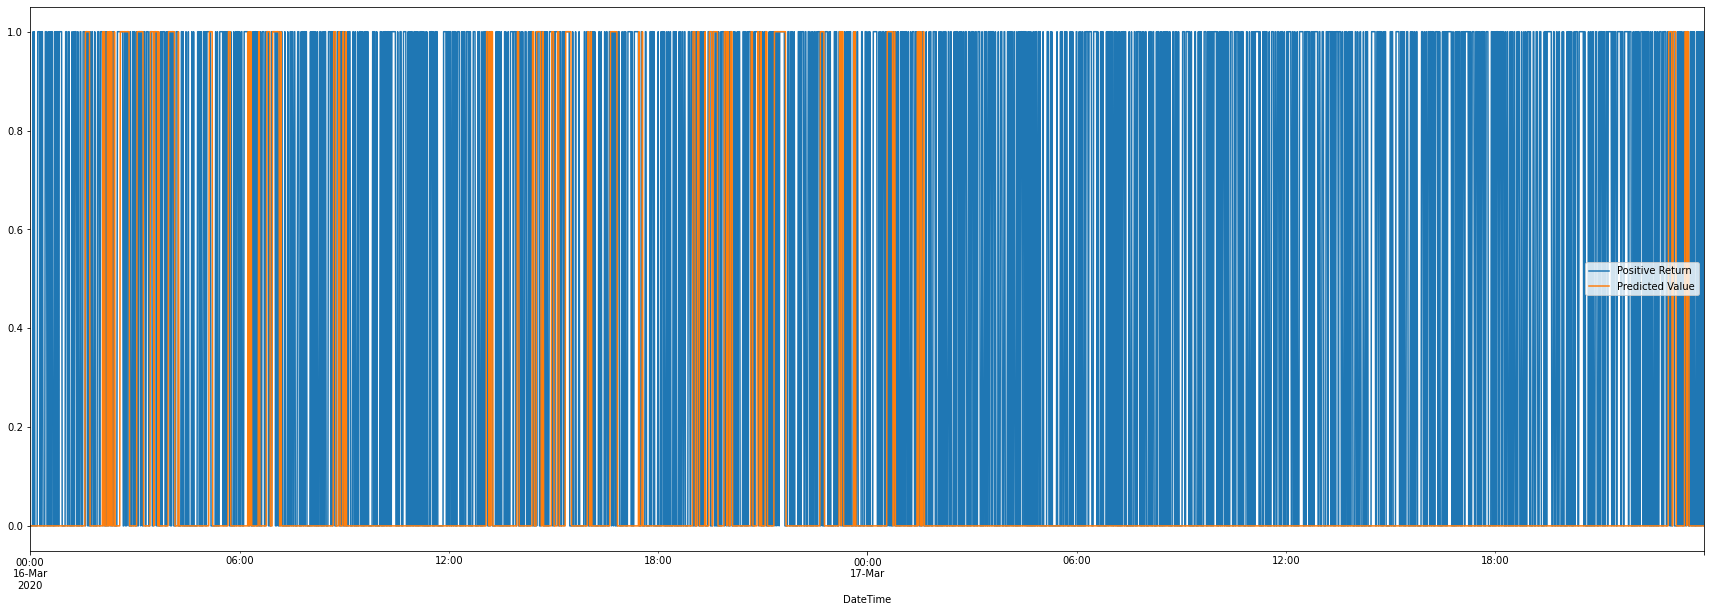

In [33]:
# display results (due to large action difficult to read over time)
Results[['Positive Return','Predicted Value']].plot(figsize=(30,10))

In [34]:
# create df for results and replace 0 with -1 in order to introduce short 
Results2 = Results
Results2['Predicted Value'] = Results['Predicted Value'].replace(0,-1)
Results2

,Positive Return,Predicted Value
DateTime,,
2020-03-16 00:00:00,0.0,-1.0
2020-03-16 00:01:00,0.0,-1.0
2020-03-16 00:02:00,0.0,-1.0
2020-03-16 00:03:00,0.0,-1.0
2020-03-16 00:04:00,0.0,-1.0
...,...,...
2020-03-17 23:55:00,0.0,-1.0
2020-03-17 23:56:00,1.0,-1.0
2020-03-17 23:57:00,1.0,-1.0


In [35]:
# provide return data in order to review success of the model
Results2['Return'] = df['return']
Results2.head()

,Positive Return,Predicted Value,Return
DateTime,,,
2020-03-16 00:00:00,0.0,-1.0,0.000000
2020-03-16 00:01:00,0.0,-1.0,-0.000135
2020-03-16 00:02:00,0.0,-1.0,-0.000108
2020-03-16 00:03:00,0.0,-1.0,-0.000431
2020-03-16 00:04:00,0.0,-1.0,-0.000512


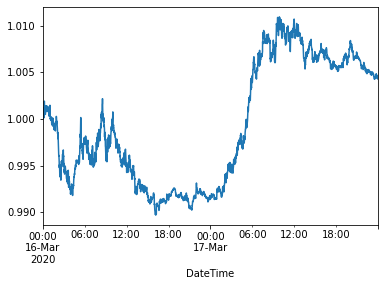

In [36]:
# plot results of the model
(1 + (Results2['Return'] * Results2['Predicted Value'])).cumprod().plot()

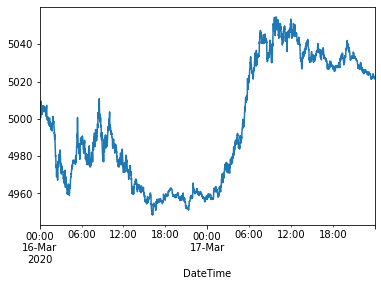

In [37]:
# show return of the model based on an investment (5000 used for realistic minimum account balance)
initial_capital = 5000

cumulative_return_capital = initial_capital * (1 + (Results2['Return'] * Results2['Predicted Value'])).cumprod()
cumulative_return_capital.plot()

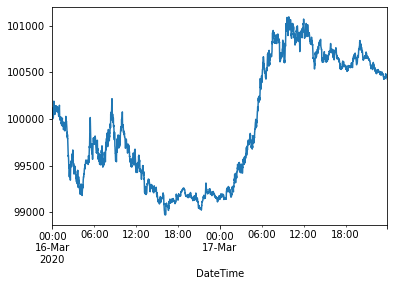

In [38]:
initial_capital = 100000

cumulative_return_capital = initial_capital * (1 + (Results2['Return'] * Results2['Predicted Value'])).cumprod()
cumulative_return_capital.plot()